<h1><center>Jupyter Dashboard with Voila</center></h1>

<center><i>Dashboard to visualize open data, based on tutorial by <a href="https://duarteocarmo.com/">Duarte OC</a> with <a href="https://github.com/voila-dashboards/voila">Voila</a>, <a href="https://pandas.pydata.org/">Pandas</a> and <a href="https://seaborn.pydata.org/">Seaborn</a>.</i></center>
<br></br>

<center><i><a href="https://github.com/walteryu/jupyter-dashboard">Source Code on Github</a></i></center>


## Introduction

This notebook is a dashboard publication tool via Jupyter-Voila. It is developed based on this [tutorial](https://github.com/duarteocarmo/interactive-dashboard-post) by Duarte O. Carmo. He has also published an article to outline his tutorial [here](https://pbpython.com/interactive-dashboards.html).

This notebook is organized into modules to complete the following tasks:

1. Data Analysis
2. Data Visualization
3. Dashboard Publication

## VTA Open Data

This dashboard visualizes cumulative monthly ridership from the VTA Open Data [Portal](http://data.vta.org/). The Portal is described as "central location for access to VTA's open data, including transit, active transportation, congestion management and more."

The [monthly ridership data](http://data.vta.org/datasets/ridership-by-route-cumulative-monthly) includes fields for train route, line type, ridership and cumulative monthly period. It consists of data from 2013 to 2018.


In [34]:
# 01 - import modules

# pandas modules for working with DataFrames
import pandas as pd

# modules for data manipulation
import numpy as np

# modules for statistical models
import scipy
from scipy import stats
import statsmodels.api as sm

# numpy modules for data visualization
import matplotlib.pyplot as plt

# adjust plot settings to output correctly
%matplotlib inline

# seaborn module for plots; built on Matplotlib package:
# https://seaborn.pydata.org/
import seaborn as sns; sns.set(color_codes=True)

# set numeric output; turn off scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# adjust default settings
pd.options.display.max_columns = 60
pd.options.display.max_rows = 35
import warnings
warnings.filterwarnings("ignore")

# import libraries
# source: https://github.com/duarteocarmo/interactive-dashboard-post
import requests
# import textblob
import plotly.express as px
pd.set_option('display.max_colwidth', -1) # don't cut my pandas dataframes


In [35]:
# 02A.01 - load data into notebook

# load data via file
# Source data: https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv
df_total = pd.read_csv('../data/Ridership_by_Route_Cumulative_Monthly.csv')

# load data via url
# https://stackoverflow.com/questions/32400867/pandas-read-csv-from-url/41880513#41880513
# url = ""
# df_total = pd.read_csv(url)

# filter by line type
# https://stackoverflow.com/questions/11869910/pandas-filter-rows-of-dataframe-with-operator-chaining
df_core = df_total[df_total['LineType'] == 'Core']

# output table info
def data_profile(df, msg):
    print(msg, '\n')
    print('Dataframe Shape:', df.shape, '\n')
    print(df.info(), '\n')
    print('Dataframe Data Types:\n')
    print(df.dtypes, '\n')

# data profile
data_profile(
    df_total,
    '*** Table Info: VTA Ridership - Cumulative Monthly Total from 2005-2018 ***'
)

# output unique values
def show_unique(col, msg):
    print('\n', msg, '\n')
    print(col.unique())

show_unique(
    df_total['Routes'],
    '*** Unique Values: VTA Ridership - Train Route ***'
)
show_unique(
    df_total['LineType'],
    '*** Unique Values: VTA Ridership - Train Line Type ***'
)

# output summary stats
def summary_stats(col, msg):
    print('\n', msg, '\n')
    print(col.describe())

summary_stats(
    df_total['Boardings'],
    '*** Summary Stats: VTA Ridership - Train Boardings for All Routes ***'
)
summary_stats(
    df_core['Boardings'],
    '*** Summary Stats: VTA Ridership - Train Boardings for Core Lines ***'
)


*** Table Info: VTA Ridership - Cumulative Monthly Total from 2005-2018 *** 

Dataframe Shape: (45144, 7) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45144 entries, 0 to 45143
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Routes       45144 non-null  int64 
 1   LineType     45144 non-null  object
 2   DayofWeek    45144 non-null  object
 3   Boardings    45144 non-null  int64 
 4   Period       45144 non-null  object
 5   Period_date  45144 non-null  object
 6   FID          45144 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 2.4+ MB
None 

Dataframe Data Types:

Routes         int64 
LineType       object
DayofWeek      object
Boardings      int64 
Period         object
Period_date    object
FID            int64 
dtype: object 


 *** Unique Values: VTA Ridership - Train Route *** 

[ 72  73  76  77  81  82  85  88  89 101 102 103 104 120 121 122 140 141
 168 180 181 182 183 185 200 201 202 

In [36]:
# 02B.01 - exploratory data analysis (eda)

# convert col to numeric type
# reference: https://stackoverflow.com/questions/47333227/pandas-valueerror-cannot-convert-float-nan-to-integer
def convert_num(col):
    # convert type
    col = pd.to_numeric(
        col,
        errors='coerce'
    )
    # print msg in case of error
    # if col.dtypes != 'int64' or 'float64':
    #     print('error: numeric conversion not successful')

# convert string to datetime
# reference: https://stackoverflow.com/questions/32888124/pandas-out-of-bounds-nanosecond-timestamp-after-offset-rollforward-plus-adding-a
def convert_date(col):
    # convert type
    col = pd.to_datetime(
        col,
        infer_datetime_format=True,
        errors = 'coerce'
    )

convert_date(df_total['Period'])
convert_date(df_total['Period_date'])


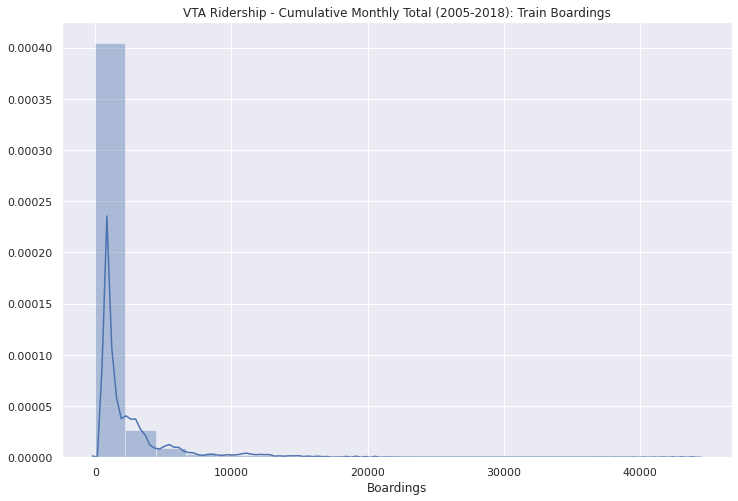

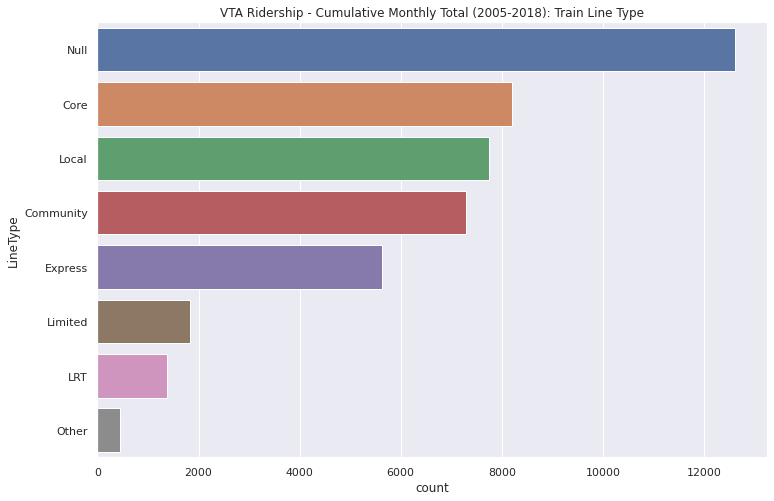

In [37]:
# 03A.01 - create count plot

# preset plot size
plt.figure(figsize=(12, 8))

# create histogram
def distplot(col, msg):
    # create plot; set size and title
    sns.distplot(col, bins=20, kde=True)
    plt.title(msg)
    plt.show()

distplot(
    df_total['Boardings'],
    'VTA Ridership - Cumulative Monthly Total (2005-2018): Train Boardings'
)

# create countplot and sort categories by value
# https://stackoverflow.com/questions/46623583/seaborn-countplot-order-categories-by-count

# preset plot size
plt.figure(figsize=(12, 8))

def cplot_sort(col, df, sort, msg):
    # create plot; set size and title
    sns.countplot(
        y=col,
        data=df,
        order=sort
    )
    plt.title(msg)
    plt.show()

# set plot size and title
cplot_sort(
    'LineType',
    df_total,
    df_total['LineType'].value_counts().index,
    'VTA Ridership - Cumulative Monthly Total (2005-2018): Train Line Type'
)


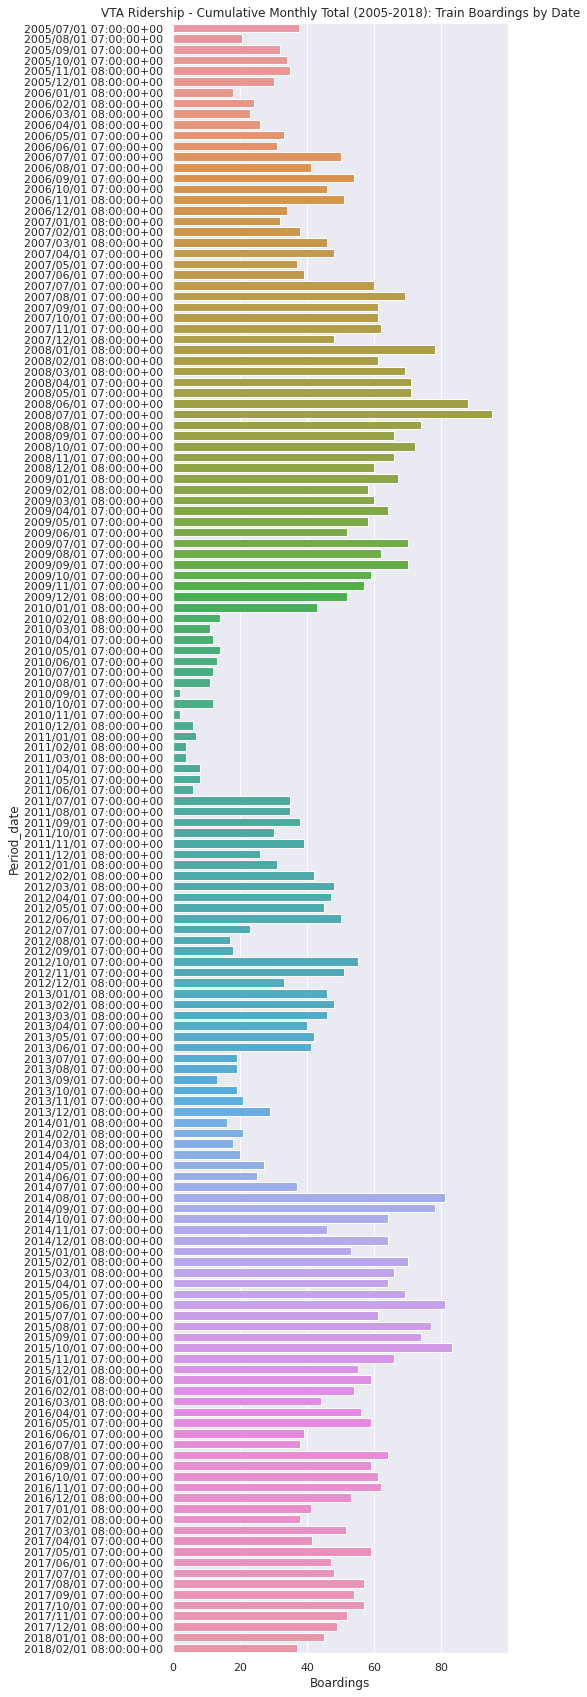

In [38]:
# 03A.02 - create bar plot

# create countplot
plt.figure(figsize=(6, 30))

# aggregate and sort for plot
# https://gist.github.com/fomightez/bb5a9c727d93d1508187677b4d74d7c1
def barplot(y_col, x_col, df, msg):
    sns.barplot(
        y=y_col,
        x=x_col,
        data=df
    )
    plt.title(msg)
    plt.show()

df_total_sort = df_total.groupby(['Period_date'])['Boardings'].aggregate(np.median).reset_index()
barplot(
    'Period_date',
    'Boardings',
    df_total_sort,
    'VTA Ridership - Cumulative Monthly Total (2005-2018): Train Boardings by Date'
)


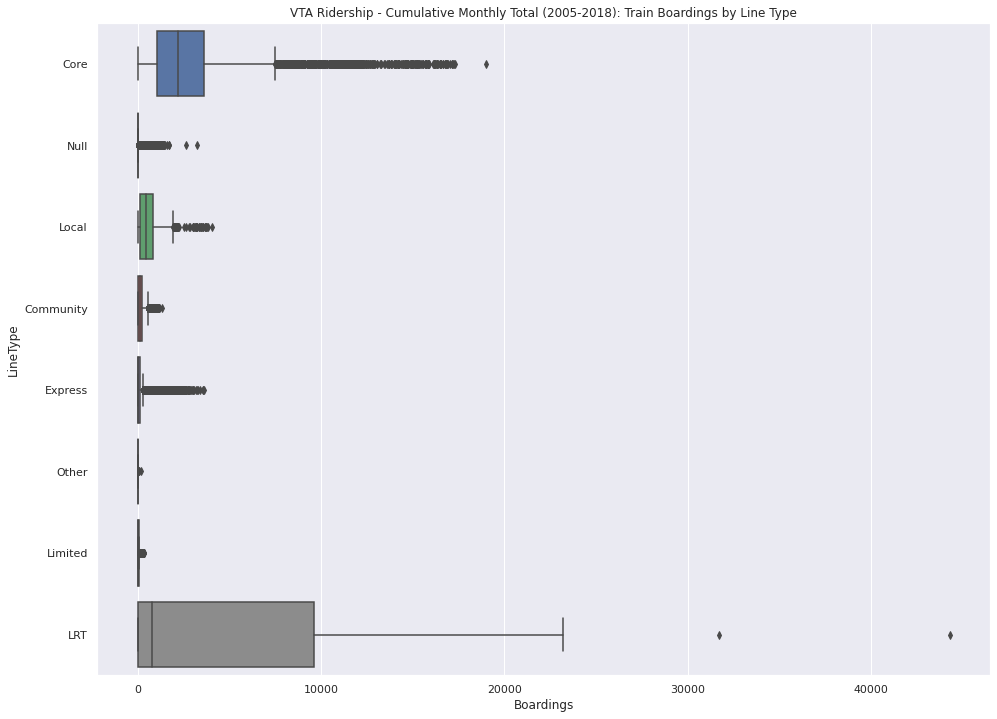

In [39]:
# 03B.01 - create box plots

# set plot size and title
plt.figure(figsize=(16, 12))

# create boxplot
def boxplot(y_col, x_col, df, msg):
    sns.boxplot(
        y=y_col,
        x=x_col,
        data=df
    )
    plt.title(msg)
    plt.show()

boxplot(
    "LineType",
    "Boardings",
    df_total,
    'VTA Ridership - Cumulative Monthly Total (2005-2018): Train Boardings by Line Type'
)

# create heatmap
# remove duplicates:
# https://stackoverflow.com/questions/13035764/remove-rows-with-duplicate-indices-pandas-dataframe-and-timeseries
# df_total = df_total.loc[~df_total.index.duplicated(keep='first')]
# df_total = df_total.pivot('DayofWeek', 'Period', 'Boardings')
# sns.heatmap(df_total)


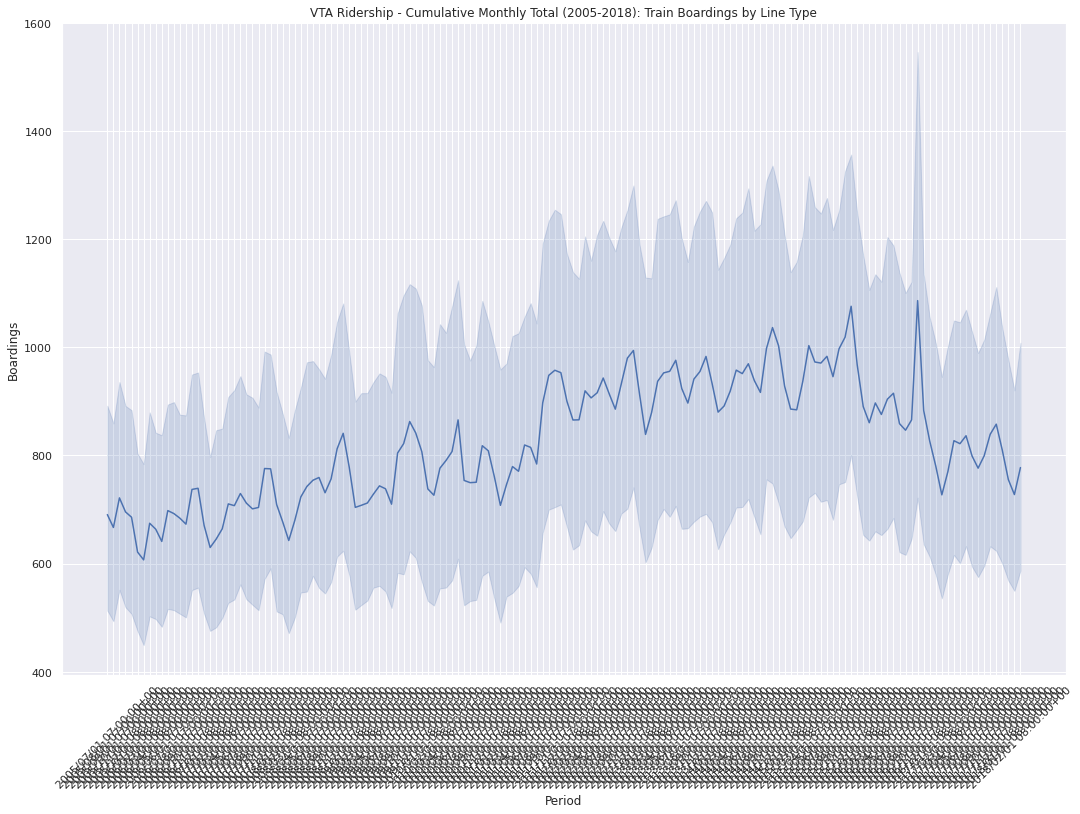

In [45]:
# 03B.02 - create time series

# set plot size and title
plt.figure(figsize=(18, 12))

# create time series plot
def time_series(x_col, y_col, df, msg):
    sns.lineplot(
        x=x_col,
        y=y_col,
        data=df
    )
    plt.title(msg)
    plt.xticks(rotation=45)
    plt.show()

time_series(
    'Period',
    'Boardings',
    df_total,
    'VTA Ridership - Cumulative Monthly Total (2005-2018): Train Boardings by Line Type'
)
